# Music segmentation analysis

- Author: Brian Siao Tick Chong
- Email: bstc@bu.edu

In [3]:
#imports

from cs591Utilities import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from cmath import polar
from numpy import pi, sin, cos, exp, abs, angle
from scipy import signal
from scipy.spatial.distance import cosine as cosineDistance
import random, math
from mpl_toolkits.mplot3d import Axes3D


%matplotlib notebook

### Part 1: Generating the self-similarity matrix M:
- All options are at the start of the code cell.
- Modified code, originally written by Wayne Snyder

You And I - Jacob Collier2.wav

Window = 0.3 seconds	upperBound = 89	startOctave = 1
distanceMeasure = cs	spectrum = norm
length = 180.0 seconds
from 0 sec to 180 sec


<IPython.core.display.Javascript object>


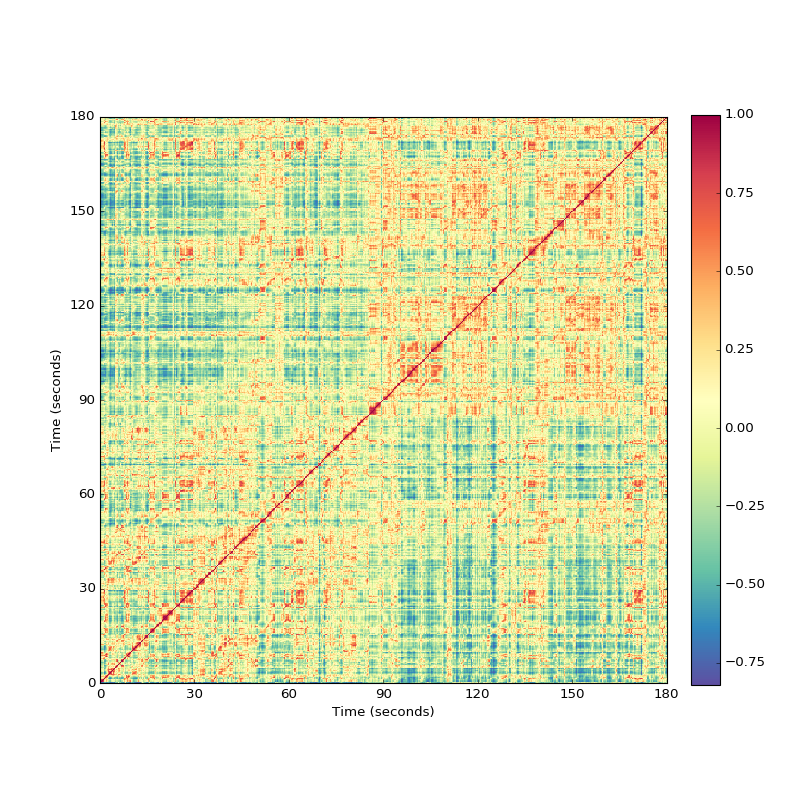

Max similarity = 1.0000000000000004
Min similarity = -0.8209314501320811


In [5]:
SR = 44100
W = 4410 + 8820  #works pretty well for most things
# W = 8820*3       #really big window
# W = 1000         #more for individual note changes
upperBound = 89
startOctave = 1
#distanceMeasure = "ed"   
distanceMeasure = "cs" 
spectrum = "norm"   
# spectrum = "square"
# spectrum = "log"
# spectrum = "cube"
length = 60*3

musicdirectory = "music/"
# title = 'Bach.WTC.1.Prelude_01.wav'
# title = 'Smoove-ImAMan2.wav'
# title = 'Brownout-Homenaje2.wav'
title = 'You And I - Jacob Collier2.wav'
# title = 'Ben Lapps - Phunkdified2.wav'
# title = 'Dont You Worry Bout A Thing - Jacob Collier2.wav'
start = 0

colormap = 'Spectral_r'
# colormap = 'Blues_r'

print(title)

print()

print("Window = " + str(W/SR) + " seconds\tupperBound = " + str(upperBound) + "\tstartOctave = " + str(startOctave))

print("distanceMeasure = " + distanceMeasure + "\tspectrum = " + str(spectrum))


# chroma functions

# piano chroma: collect amplitudes of frequencies around the piano key
# frequencies


# Array of lower bound half-way to next lower semitone, so
# F[0] is between A0 and Bb0, F[1] is between Bb0 and B0, etc.

F = [0] * upperBound
incr = 2**(1/12)          # this is the interval between each semitone
F[0] = startOctave*27.5/(2**(1/24))

for k in range(1,len(F)):
    F[k] = F[k-1] * incr

# takes a spectrum, complex or real-valued, and sum all values between
# the bounds in F.  Incr is distance between each of the bins. 
    
def fillChroma(S,Incr,spec='norm',method='sum'):
    C = [0] * (len(F)-1)   #  Chroma for each of piano keys
                           # C[m] is bounded by [ F[m] .. F[m+1] )

    # what kind of spectrum
    if(spec=='square' or method=='rms'):
        for k in range(len(S)):
            S[k] = abs(S[k])**2
    elif(spec=='cube'):
        for k in range(len(S)):
            S[k] = abs(S[k])**3
    elif(spec=='log'):
        for k in range(len(S)):
            S[k] = np.log(abs(S[k])+1)
    else: # normal
        for k in range(len(S)):
            S[k] = abs(S[k])
            
    for k in range(len(S)): # for every frequency (could be squared, logged, etc.) in the spectrum
        f = k * Incr       # freq of bin i
        if(f > F[-1]):     #if the frequency is larger than the largest frequency, break
            break
        for m in range(len(C)): #for every semitone of Chroma C
            # does S[k] get added to C[m]
            if(F[m] <= f < F[m+1]): #if f is between two semitones
                if(method == 'max'):      #if method is to only put max value in bin,
                    C[m] = max(C[m],S[k])  #get the max of the current value in this bin versus the new frequency
                elif(method == 'sum'):    #if method is to sum frequencies in bin
                    C[m] += S[k]           #sum the frequencies
                else:                     #otherwise,
                    C[m] += S[k]           #sum the frequencies
    if(method=='rms'):
        for k in range(len(C)):
            C[k] = C[k]**0.5
    
    return C


X = readWaveFile(musicdirectory + title)

leng = min(len(X),length*SR) #how many samples should be analyzed

X = X[start*SR:start*SR + leng] #get samples to analyze

print("length = " + str(round4(leng/SR)) + " seconds")
print("from {} sec to {} sec".format(start,start + length))

def cosineSimilarity(A,B):
    A = np.array(A)
    B = np.array(B)
    prod = np.dot(A,B)
    mag1 = np.sqrt(A.dot(A))
    mag2 = np.sqrt(B.dot(B))
    
    return -(1 - 2*prod/(mag1*mag2))

#Self-similarity matrix
def SSM(X,Incr,axes_option='seconds'): #can specify if you want the x/y axis to be in 'seconds' or 'windows'
    N = len(X)//W 
    C = []
    f = SR / W
    fig,ax = plt.subplots(figsize=(10, 10))
    
    for k in range(0,len(X),W):
        S = realFFT(X[k:(k+W)])
        A =  fillChroma(S,Incr,spec=spectrum) 
        C.append(A)
    
    #Create similarity matrix M
    M = np.zeros([len(C),len(C)])
    
    max_dist = -1
    min_dist = 1
    for r in range(len(C)):
        for c in range(len(C)):
            if(distanceMeasure=="cs"):
                # takes both chromas (however many dimensions the chroma is) 
                # and calculates cosine distance between these two vectors
                M[r][c] = cosineSimilarity(C[r],C[c])
                if (M[r][c] > max_dist):
                    max_dist = M[r][c]
                if (M[r][c] < min_dist):
                    min_dist = M[r][c]
            else:
                M[r][c] = ED(C[r],C[c]) #an implementation for ED was not provided with the code this is based on
    print("Max similarity = {}".format(max_dist))  
    print("Min similarity = {}".format(min_dist))
    T = [k*W/SR for k in range(N)]
    
    #Modify axes
    ax.set_xlim(0,np.shape(M)[0]) #sets the x axis data limits, necessary for getting the x_ticks
    ax.set_ylim(0,np.shape(M)[1]) #sets the y axis data limits, necessary for getting the y_ticks
    
    fig.canvas.draw() #sets the labels of the axes so they can be retrieved/modified
    
    window_in_seconds = W/SR
    if (axes_option == 'seconds'):
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Time (seconds)')
        
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*window_in_seconds))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*window_in_seconds))
        ax.yaxis.set_major_formatter(ticks_y)
    else:
        ax.set_xlabel('Window = {} samples = {} seconds'.format(W, window_in_seconds))
        ax.set_ylabel('Window = {} samples = {} seconds'.format(W, window_in_seconds))
        pass #keep the xticklabels the window numbers
    
    #Draw matrix
    im = plt.imshow(np.flipud(M), cmap=colormap, interpolation='nearest', extent=(0,np.shape(M)[0],0,np.shape(M)[1]))
    plt.colorbar(im, fraction=0.046, pad=0.04)

    return M

M = SSM(X,int(SR/W))

# displaySignal(X)
# writeWaveFile(musicdirectory + 'analyzedsection_' + title, X)
    


### Part 2: Calculating Novelty Scores
References:
- https://infoscience.epfl.ch/record/190844/files/2013_Audio%20Novelty-based%20Segmentation%20of%20Music%20Concerts.pdf
- https://www.fxpal.com/publications/automatic-audio-segmentation-using-a-measure-of-audio-novelty.pdf

In [6]:
#Options for calculating Novelty Scores:
K_list = [16,64]  # sizes of kernel to plot
gaussian = True   # gaussian kernel
xaxis_scaler = 3

In [7]:
#Multiply matrices element-wise (not dot product)
def multiplyMatrices(A,B):
    if (isinstance(A,np.matrixlib.defmatrix.matrix)):
        A = A.tolist()
    if (isinstance(B,np.matrixlib.defmatrix.matrix)):
        B = B.tolist()

    X = np.zeros((len(A),len(A)))
    for i in range(len(A)):
        for j in range(len(A)):
            X[i][j] = A[i][j]*B[i][j] #multiply each corresponding element

    return X
      

In [8]:
#Creates a kernel for generating novelty scores with the option of creating a Gaussian kernel
def createKernel(K,gaussian=True):
    kernel = np.matrix([[1, -1], [-1, 1]])
    scaler = np.ones(shape=(int(K/2),int(K/2)))
    kernel = np.kron(kernel,scaler)
    
    if (gaussian):
        gausskernel = makeGaussian(K,K/1.5)
        kernel = multiplyMatrices(kernel,gausskernel)
        
    return kernel

<IPython.core.display.Javascript object>


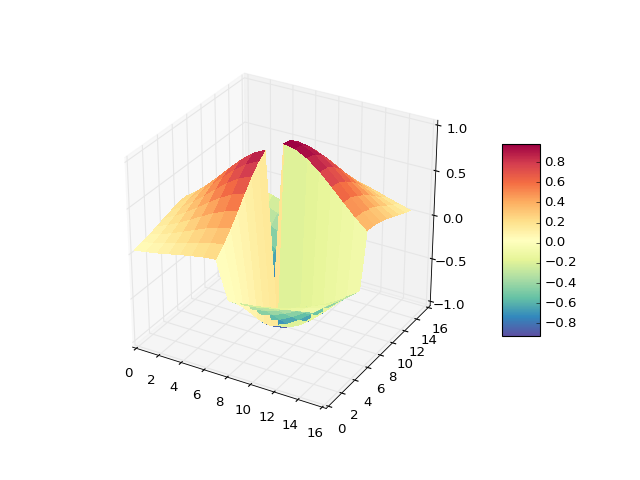

In [9]:
# This function makeGaussian was found here: https://gist.github.com/andrewgiessel/4635563 
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

# 3D visualization of kernel matrix
K = 16
X = np.arange(0, K)
Y = np.arange(0, K)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, createKernel(K), rstride=1, cstride=1, cmap='Spectral_r', linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


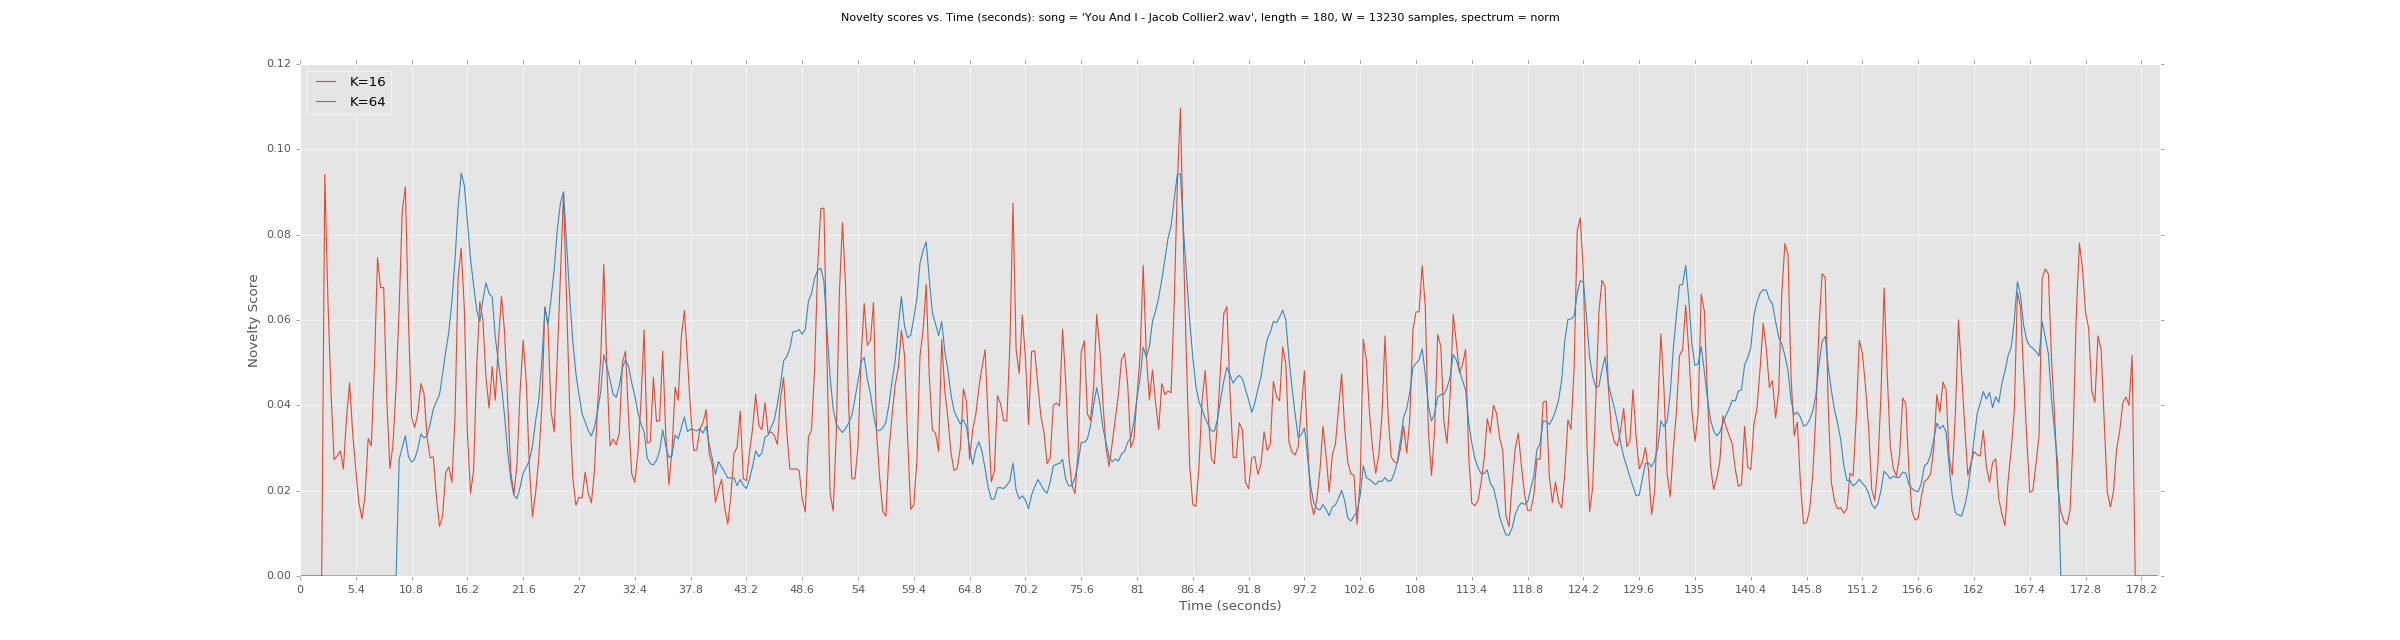

In [10]:
#Calculates and normalizes novelty scores using a kernel of size K and returns them 
def noveltyScores(M,K): #can specify if you want the x/y axis to be in 'seconds' or 'windows'

    # Create kernel that will be multiplied with the sliding window
    kernel = createKernel(K,gaussian)
    
    # Calculate novelty scores
    novelty_scores = [0]*len(M) #holds all novelty scores
    for row,similarities in enumerate(M):
        window = [0]*K  #window holds the current rows of similarities in the sliding window
        if (row < len(M)-K): #if the sliding window can still fit
            #get the window of similarities
            for i in range(0,K): 
                #row is decided by row+i
                #column numbers for elements retrieved are fixed for the current window (row:row+K)
                window[i] = M[row+i][row:row+K]

            #multiply the matrices 
            product = multiplyMatrices(kernel,window)       #multiply kernel with window of similarities
            cross_similarity = sum(sum(product))            #sum all elements of matrix
            novelty_scores[row+int(K/2)] = cross_similarity #add cross similarity to novelty_scores array

    # Normalize novelty scores
    norm_novelty_scores = novelty_scores/np.linalg.norm(novelty_scores)
    
    return norm_novelty_scores

#Plots all novelty scores for multiple kernel sizes if specified
def plotNoveltyScores(M,K_list=[32],axes_option='seconds'):

    # Plot style
    plt.style.use('ggplot')
#     plt.style.use('color_by_value')

    # Plot novelty scores
    fig,ax = plt.subplots(figsize=(30, 8))
    
    for K in K_list:
        plt.plot(noveltyScores(M,K), label='K={}'.format(K))
    
    plt.legend(loc=2)
    ax.set_ylabel('Novelty Score')
    
    #Modify x-axis to be in terms of time if specified
    ax.set_xlim(0,np.shape(M)[0]) #sets the x axis data limits, necessary for getting the x_ticks
    fig.canvas.draw() #sets the labels of the axes so they can be retrieved/modified
    
    window_in_seconds = W/SR
    if (axes_option == 'seconds'):
        ax.set_xlabel('Time (seconds)')
        
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*window_in_seconds))
        ax.xaxis.set_major_formatter(ticks_x)
        
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, window_in_seconds*length/xaxis_scaler))
        
        plt.suptitle('Novelty scores vs. Time (seconds): song = \'{}\', length = {}, W = {} samples, spectrum = {}'.format(title,length,W,spectrum))
    else:
        ax.set_xlabel('Window = {} samples = {} seconds'.format(W, window_in_seconds))
        
        plt.suptitle('Novelty scores vs. Window count: song = \'{}\', length = {} seconds, W = {} samples, spectrum = {}'.format(title,length,W,spectrum))
        
    plt.show()
    
plotNoveltyScores(M,K_list)

### Part 2.1: Animating Novelty Scores
MUST INSTALL FFMPEG: http://www.wikihow.com/Install-FFmpeg-on-Windows

<IPython.core.display.Javascript object>


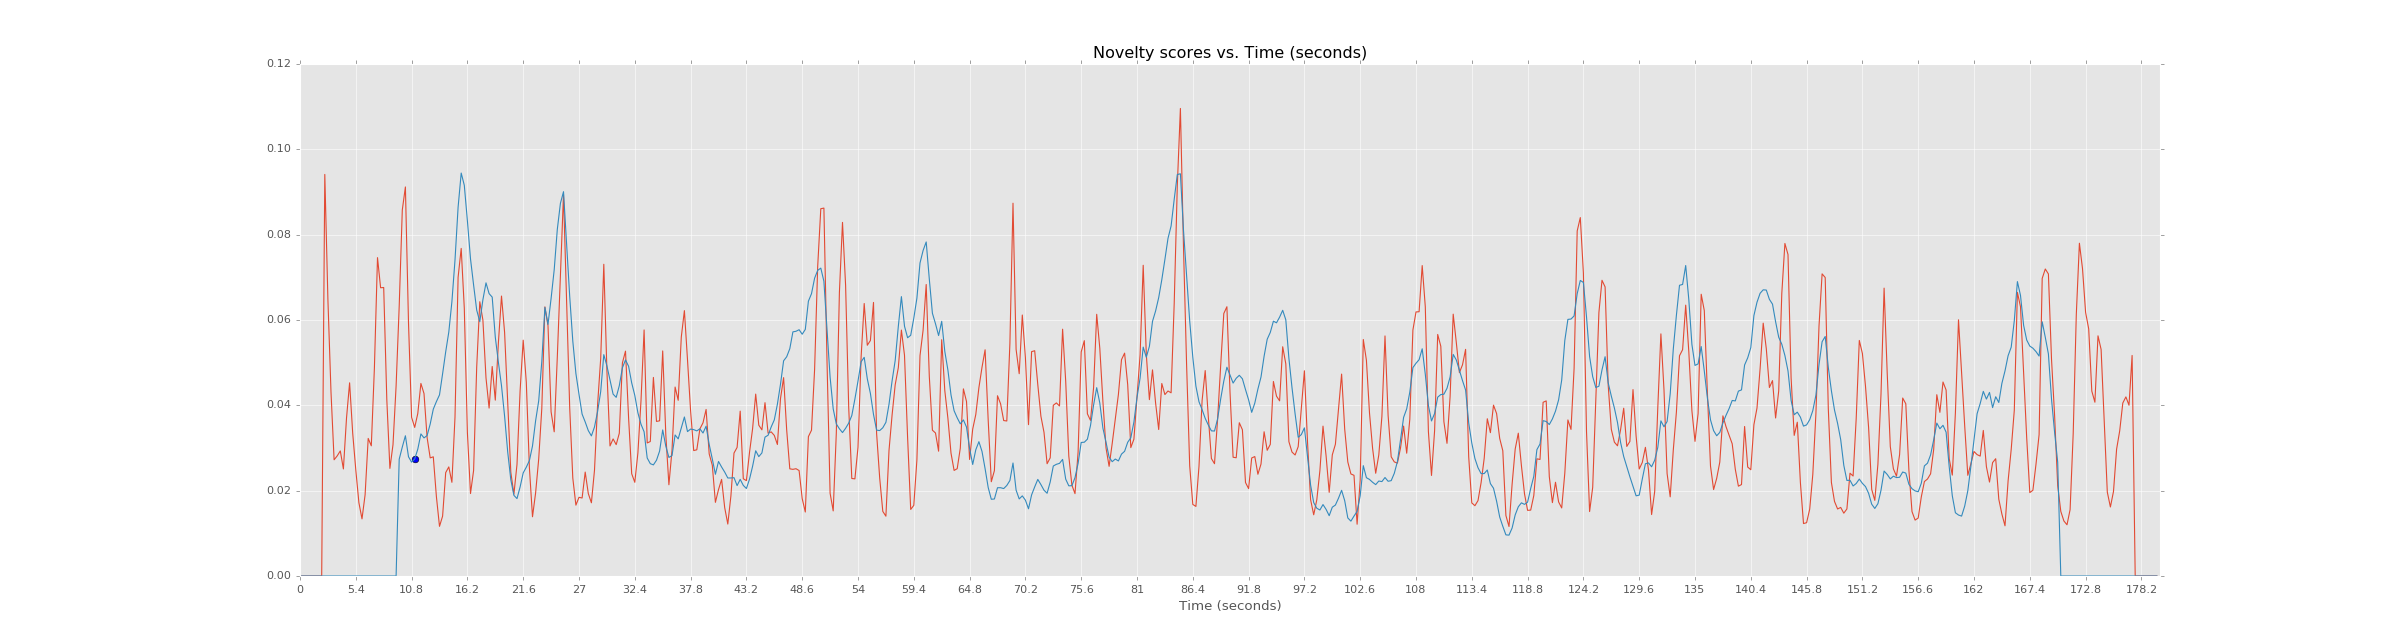

In [13]:
K_to_trace = 64 # Which kernel size do you want to follow on the graph of novelty scores? Specify one number here.

from matplotlib import animation
from IPython.display import HTML
import base64

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        anim.save(title + "_novelty-scores-animation.mp4", extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])

        video = open(title + "_novelty-scores-animation.mp4","rb").read()

    anim._encoded_video = base64.b64encode(video)
    return VIDEO_TAG.format(anim._encoded_video)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(30, 8))
plt.title('Novelty scores vs. Time (seconds)')
ax = plt.axes()
particles, = ax.plot([], [], 'bo', ms=6)

for K in K_list:
    plt.plot(noveltyScores(M,K), label='K={}'.format(K))
novscores = noveltyScores(M,K_to_trace)

window_in_seconds = W/SR
ax.set_xlabel('Time (seconds)')
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*window_in_seconds))
ax.xaxis.set_major_formatter(ticks_x)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, window_in_seconds*length/xaxis_scaler))

# initialization function: plot the background of each frame
def init():
    particles.set_data([], [])
    return particles

# animation function.  This is called sequentially
def animate(i):
    particles.set_data(i,novscores[i])
    
    return particles,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, interval=(W/SR)*1000, blit=True)
anim_to_html(anim)

animation.rcParams['animation.html'] = 'html5'